In [12]:
from qiskit import QuantumRegister
from qiskit.circuit import QuantumCircuit, Parameter

from qiskit_cold_atom.spins.spins_gate_library import RydbergFull
from qiskit_cold_atom.spins import SpinSimulator

import numpy as np

# Remote systems

Let us attempt to run the simulation on a remote backend

In [2]:
from qiskit_cold_atom.providers import ColdAtomProvider
from pprint import pprint

In [3]:
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#        "https://qlued.alqor.io/api/v2/rydberg",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

In [4]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_rydberg_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rx', 'rz', 'rydberg_block', 'rydberg_full', 'barrier', 'measure']


first a single job

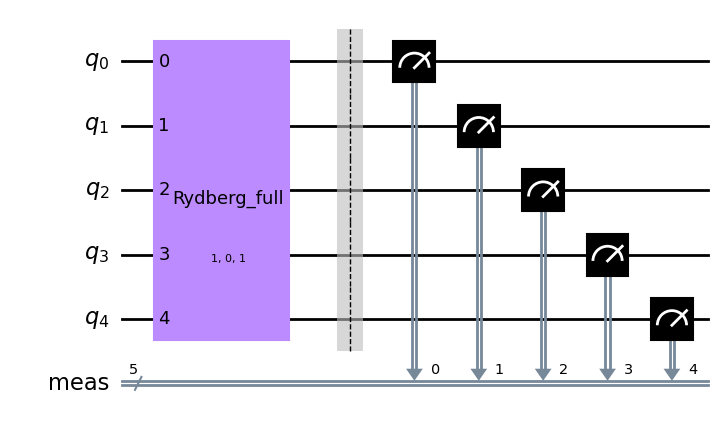

In [5]:
Nwires = 5
qc = QuantumCircuit(5)

all_modes=range(Nwires)
qc.rydberg_full(omega = 1, delta =0, phi = 1, modes=all_modes)

qc.measure_all()
qc.draw(output='mpl')

In [6]:
job1 = spin_device_backend.run(qc, shots=500)

In [7]:
job1.job_id()

'20230414_132732-rydberg-fretchen-b4774'

In [8]:
job_retrieved1 = spin_device_backend.retrieve_job(job_id=job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


now a series of jobs

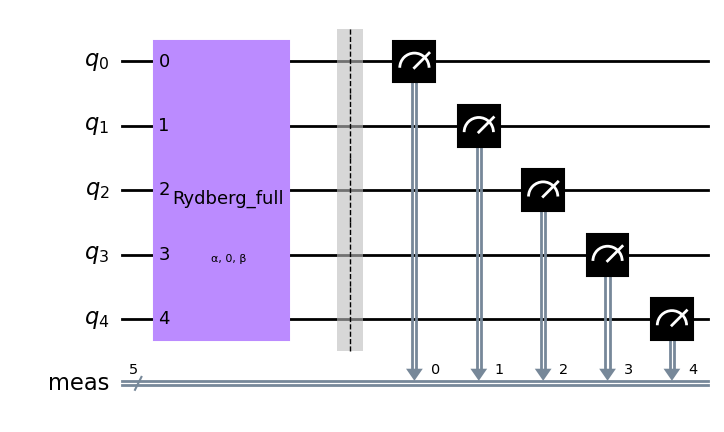

In [9]:
Nwires = 5
qc2 = QuantumCircuit(5)

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc2.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc2.measure_all()
qc2.draw(output='mpl')

In [13]:
phases = np.linspace(0, 2*np.pi,15)

circuit2_list = [
    qc2.assign_parameters(
        {alpha: phase, beta: phase*2},
        inplace=False,
    )
    for phase in phases
]

In [14]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [15]:
job2.job_id()

'20230414_132821-rydberg-fretchen-222d6'

In [16]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


In [17]:
result2 = job_retrieved2.result()

make this a card of averages

In [18]:
outcomes = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

In [19]:
means_1 = outcomes.mean(axis=1)
means_1.shape

(15, 5)

In [20]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'time')

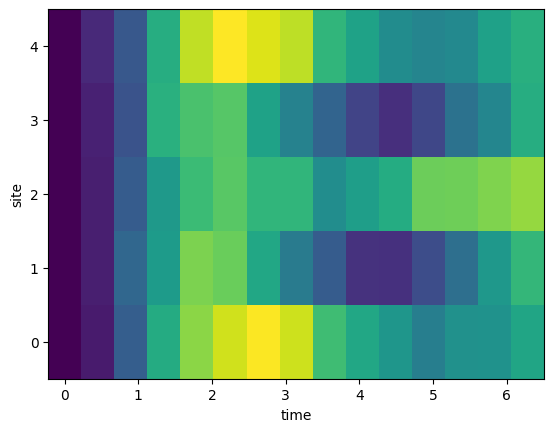

In [21]:
f, ax = plt.subplots()
ax.pcolormesh(phases,np.arange(5), means_1.T)
ax.set_ylabel('site')
ax.set_xlabel('time')

# local simulation

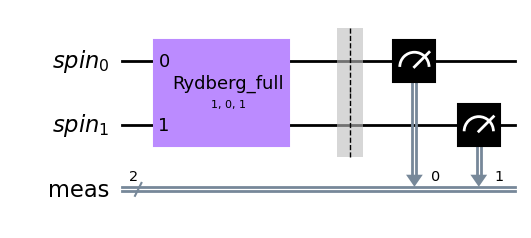

In [22]:
Nwires = 2
backend = SpinSimulator()
qc = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
qc.rydberg_full(omega = 1, delta =0, phi = 1, modes=all_modes)

qc.measure_all()
qc.draw(output='mpl')

In [23]:
job = backend.run(qc, shots=500)
counts = job.result().get_counts()

QiskitColdAtomError: 'length of gate labels 1 does not match qargs [0, 1] of the gates'

run several circuits

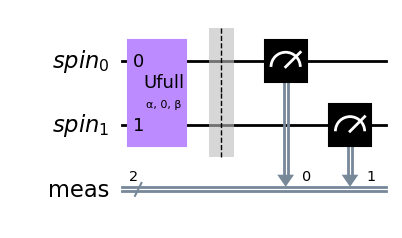

In [1]:
Nwires = 2
backend = SpinSimulator()
qc = QuantumCircuit(QuantumRegister(Nwires, "spin"))

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc.measure_all()
qc.draw(output='mpl')

In [2]:
import numpy as np

In [3]:
phases = np.linspace(0, 2*np.pi,5)

circuit_list = [qc.bind_parameters({alpha: phase, beta: phase* 1e4 + np.random.rand()}) for phase in phases]
job = backend.run(circuit_list, shots=500)
counts1 = job.result().get_counts()


QiskitColdAtomError: 'length of gate labels 1 does not match qargs [0, 1] of the gates'